__Goal__: of this notebook is to have a glimpse on how easy it is to play with neural networks with Pytorch and illustrate the expressive power and versatility of neural networks:
- We first go through their discriminative power (i.e. classification) on the very classical MNIST data-set. In particular we see how to
    - Define a neural model as a torch.nn.Module.
    - Have a glimpse at convolutional layers, activations etc...
    - Use DataLoader and Data-Augmentation and the intimate link with Stochastic Gradient Descent.
    - How to train the model with optimizers.
    - Perform inference!

- Then we explore neural network representation with fun application like style transfer.
    - Load a pre-trained model.
    - What the model has learnt at each layer.
    - How to define the style transfer problem.
    - Play with it!

- If we have time we go over auto-encoder to explore the 'latent space' of these models.

__Recommended sources__: http://cs231n.github.io/

# 1) First Part: Discriminative Network (classification) on MNIST

__Load the MNIST dataset__

In [1]:
%matplotlib inline
import torch
import torch.nn as nn
import torchvision  # for the datasets.
import torchvision.transforms as transforms

# TODO: give the nice references...


# Which transformations to apply to each data point when sampling data point.
# Here simply transform the data-point into a tensor and normalize it.
# A tensor is just a multidimensional matrix!
# torch.tensor is 'equivalent' to np.array
transform = transforms.Compose([
                                torchvision.transforms.ToTensor(),
                                torchvision.transforms.Normalize(
                                (0.1307,), (0.3081,))
                                           ])


mnist_train = torchvision.datasets.MNIST('data/', train=True, transform=transform,
                                         target_transform=None, download=True)
mnist_test = torchvision.datasets.MNIST('data/', train=False, transform=transform,
                                        target_transform=None, download=True)


batch_size_train = 64  # often a power or 2.  
data_loader_train = torch.utils.data.DataLoader(mnist_train,
                                                batch_size=batch_size_train,
                                                shuffle=True)

__Define the Model__

In [2]:
import torch.nn.functional as F

# This is the very generic structure for neural models.
# nn.Conv2d(nbr_input_channel, nbr_output_channel, size_kernel)
# Be careful of the dimension for the First Linear layer (= fully-connected).
class LeNet5(nn.Module):
    def __init__(self):
        # This
        super(LeNet5, self).__init__()
        self.conv1 = nn.Conv2d(1, 4, (5, 5), padding=2)
        self.conv2 = nn.Conv2d(4, 16, (5, 5))
        self.lin1 = nn.Linear(16*5*5, 120)
        self.lin2 = nn.Linear(120, 84)
        self.lin3 = nn.Linear(84, 10)
        self.name = 'LeNet5'

    def forward(self, x):
        # simply define the forward pass.
        x = F.relu(F.max_pool2d(self.conv1(x), (2, 2)))
        x = F.relu(F.max_pool2d(self.conv2(x), (2, 2)))
        x = x.view(-1, 16*5*5)
        x = F.relu(self.lin1(x))
        x = F.relu(self.lin2(x))
        x = self.lin3(x)
        # Note that we are outputing 
        return x

__Train the Model__


In [3]:
import torch.optim as optim

model = LeNet5()
model.train()
nbr_epoch = 5  # Number of time we visit the full data set. Up to you and your test loss

# Choose on which device to store the tensor (i.e. the tensor of the weights)
# Here it does not apply, you train things of cpu, but it is just to observe how easy it is with pytorch
# to adapt to the computer infrastructure.
if torch.cuda.is_available():
    device = 'cuda'
else:
    device = 'cpu'

# Define the loss!
criterion = nn.CrossEntropyLoss()  # You can choose many others!
# Same as nn.NLLLoss() but this one takes the logsoftmaxes, not the logit...

# Choose your optimizer and parameters!
# usually there are some guidelines on how to choose the hyper-parameters. Or CV...
learning_rate = 0.01
momentum = 0.9
optimizer = optim.SGD(model.parameters(),
                      lr=learning_rate,
                      momentum=momentum)

for idx_epoch in range(nbr_epoch):
    counter = 0
    for batch_idx, (data, target) in enumerate(data_loader_train):
        # set the data to the right device
        data = data.to(device)
        target = target.to(device)
        # forget the previous gradient.
        optimizer.zero_grad()
        logit = model(data)
        loss = criterion(logit, target)
        # compute the gradients!!
        loss.backward()
        # Essentially do gradient descent, i.e. weight_{t+1} = weight_t - lr* gradient...
        optimizer.step()
        counter += 1
        if counter % 100 == 0:
            print('batch {} at epoch {} with loss {}'.format(counter,
                                                             idx_epoch,
                                                             loss.item()))
    # save the model!
    # TODO: check that the folder mnist_models/ exists!
    torch.save(model.state_dict(), 'mnist_models/' + '_epoch_' + str(idx_epoch))

batch 100 at epoch 0 with loss 0.8690972328186035
batch 200 at epoch 0 with loss 0.17677952349185944
batch 300 at epoch 0 with loss 0.32520440220832825
batch 400 at epoch 0 with loss 0.22693923115730286
batch 500 at epoch 0 with loss 0.10290158540010452
batch 600 at epoch 0 with loss 0.12395676970481873
batch 700 at epoch 0 with loss 0.06251558661460876
batch 800 at epoch 0 with loss 0.10109954327344894
batch 900 at epoch 0 with loss 0.04423292353749275
batch 100 at epoch 1 with loss 0.08614327013492584
batch 200 at epoch 1 with loss 0.11520978808403015
batch 300 at epoch 1 with loss 0.09905564039945602
batch 400 at epoch 1 with loss 0.015462476760149002
batch 500 at epoch 1 with loss 0.01499850582331419
batch 600 at epoch 1 with loss 0.023648276925086975
batch 700 at epoch 1 with loss 0.03535902500152588
batch 800 at epoch 1 with loss 0.005344517529010773
batch 900 at epoch 1 with loss 0.008754827082157135
batch 100 at epoch 2 with loss 0.02118830941617489
batch 200 at epoch 2 with lo

__Evaluate the model__

In [4]:
# accuracy on test of the big network
data_loader_test = torch.utils.data.DataLoader(mnist_test,
                                               batch_size=1,
                                               shuffle=True)

def accuracy(model, data_loader_test, nbr=1000):
    pos = 0
    count = 0
    for data, target in data_loader_test:
        data = data.to(device)
        target = target.to(device)
        assert target.shape[0] == 1
        if torch.argmax(model(data).squeeze()).item() == target.item():
            pos += 1
        count += 1
        if count > nbr:
            break
    accuracy = pos/count
    return(accuracy)

for idx in range(nbr_epoch):
    PATH = 'mnist_models/_epoch_{}'.format(idx)
    model.load_state_dict(torch.load(PATH))
    model.to(device)
    model.eval()  # Do it for principle..
    acc = accuracy(model, data_loader_test)
    print('test accuracy is {} at epoch {}'.format(acc, idx))

test accuracy is 0.974025974025974 at epoch 0
test accuracy is 0.988011988011988 at epoch 1
test accuracy is 0.983016983016983 at epoch 2
test accuracy is 0.9820179820179821 at epoch 3
test accuracy is 0.987012987012987 at epoch 4


__How to Data Augmentation in Two lines:__ It is simply small transformation of the images that do not modify the label. For instance
- Add some random pixel-wise noise
- flip the image
- translate the pixel etc..

There is a very large variety of possible data-augmentation. When training your network and load batche of data, the data-point will be applied the following transformation:

In [5]:
transform = torchvision.transforms.Compose([
                                            transforms.RandomHorizontalFlip(0.5),
                                            transforms.RandomAffine(degrees=10,
                                                                    translate=(0.1, 0.1)),
                                           torchvision.transforms.ToTensor(),
                                           torchvision.transforms.Normalize(
                                            (0.1307,), (0.3081,))
                                           ])

__How to Randomly Initialize the Parameters:__ Because so far we have not specified what we wanted the initial weights to be!!

In [6]:
import numpy as np

# There are many way to define randomness on the initialization of the weights.
def init_weights(m, type_ini='uniform'):
    '''
    Initialization of neural net.
    '''
    assert type_ini in ['uniform', 'gaussian', 'general']
    # for every Linear layer in a model..
    if type(m) == nn.Linear:
        if type_ini == 'uniform':
            m.weight.data.uniform_(0.0, 1.0)
            m.bias.data.fill_(0)
        elif type_ini == 'general':
            n = m.in_features
            y = 1.0/np.sqrt(n)
            m.weight.data.uniform_(-y, y)
            m.bias.data.fill_(0)
        elif type_ini == 'gaussian':
            y = m.in_features
            # m.weight.data shoud be taken from a normal distribution
            m.weight.data.normal_(0.0, 1/np.sqrt(y))
            # m.bias.data should be 0
            m.bias.data.fill_(0)

model.apply(lambda m: init_weights(m, type_ini='general'))

LeNet5(
  (conv1): Conv2d(1, 4, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv2): Conv2d(4, 16, kernel_size=(5, 5), stride=(1, 1))
  (lin1): Linear(in_features=400, out_features=120, bias=True)
  (lin2): Linear(in_features=120, out_features=84, bias=True)
  (lin3): Linear(in_features=84, out_features=10, bias=True)
)

# Second Part: Style Transfert

__Goal__: Neural Networks are not just good at classifying, they also provide rich representations of data which can be usefull in a variety of contexts.

__Example of Style Transfert__: Write $f_{\theta_0}$ a trained neural network with parameters $\theta_0$ (which will not be optimized anymore). And now consider two images: image_content and image_style. We want to change the style of image_content to the style of image_style while keeping the structure of image_content.

__One important fact__: Layers of convolutional neural networks encode different information of an image. Each layer output is a different representation of the image. The first layers encodes detailed information (i.e. style) because the networks has not yet mixed up local information. The last layers encode more the content because it mixes the various local structures.

__Method__: Take an initial random image $x$ and ask simultaneously that 
 - The deep layers of x via $f_{\theta}$ matches to the deep layers of image_content : i.e. force $x$ to have the content of image_content.
 - The Gram matrix of the first layers of x via $f_{\theta}$ matches to gram matrix of the first layers of image_content : i.e. force $x$ to have the style of image_style.
 
__Technical Aspect__: Optimization is over the input of the neural network, not on its weigths!!

__Reference__: 
- Simonyan et Zisserman (2015). $\textit{Very Deep Convolutional Networks For Large Scale Image Recognition}.$
- Gatys et al. (2015). $\textit{Image Style Transfer Using Convolutional Neural Networks}.$
- https://pytorch.org/tutorials/advanced/neural_style_tutorial.html

__Pytorch tips__:
- Very easy to work with CPU or GPU via making sure that the tensors are on 'cpu' or 'cuda'.
-

In [90]:
import numpy as np
import matplotlib.pyplot as plt

import torchvision.models as models
import torch
import torch.optim as optim
import torch.nn.functional as F
import torch.nn as nn
import torchvision.transforms as transforms
from torchvision.utils import save_image

import pdb  # good for debugging!!

import copy
from PIL import Image  # for image processing!

__LOAD CONTENT AND STYLE IMAGE__ Please choose your own images!

In [93]:
if torch.cuda.is_available():
    device = 'cuda'
else:
    device = 'cpu'

imsize = 128


def image_loader(image_name):
    loader = transforms.Compose([
        transforms.Resize((imsize, imsize)),  # scale imported image
        transforms.ToTensor()])  # transform it into a torch tensor
    image = Image.open(image_name)
    # fake batch dimension required to fit network's input dimensions of (batch_size, channel, H, W)
    image = loader(image).unsqueeze(0)
    return image.to(device, torch.float)


style_img = image_loader('images/content.jpg')
content_img = image_loader('images/style.jpg')

assert style_img.size() == content_img.size(), \
    "we need to import style and content images of the same size"

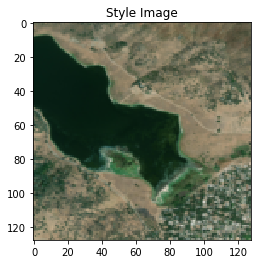

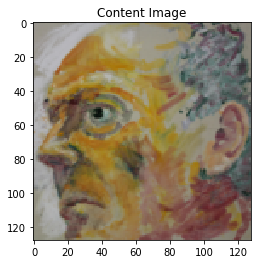

In [73]:
def imshow(tensor, title=None):
    image = tensor.cpu().clone()  # we clone the tensor to not do changes on it
    image = image.squeeze(0)      # remove the fake batch dimension
    image = transforms.ToPILImage()(image)
    plt.imshow(image)
    if title is not None:
        plt.title(title)
    plt.pause(0.001) # pause a bit so that plots are updated


plt.figure()
imshow(style_img, title='Style Image')

plt.figure()
imshow(content_img, title='Content Image')

__Load pre-trained model__


In [81]:
# two modes: eval() or train()
# may not be usefull here but it is a good habit to distinguish!
model = models.vgg19(pretrained=True).features.to(device).eval()

__Defining the content and Style Loss:__ 
- Given an image $x$ and a chosen $\text{content layer}$, write $f_c(x)$ the activations of the neural network at this layer. The content loss is then $L_c(x) = ||f_c(x) - f_c(img_{content})||_2^2$.
- For the style write $f_s(x)$ the activations of the neural network at a chosen layer that is supposed to capture the style. The style loss is then $L_s(x) = ||G(f_s(x)) - G(f_s(img_{style}))||$, where $G()$ compute the gram matrix of the layer $f_s(x)$.

In [82]:
class ContentLoss(nn.Module):
    def __init__(self, target,):
        super(ContentLoss, self).__init__()

        self.target = target.detach()

    def forward(self, input):
        self.loss = F.mse_loss(input, self.target)
        return input


class StyleLoss(nn.Module):

    def gram_matrix(self, input):
        a, b, c, d = input.size()  # a=batch size(=1)
        # b=number of feature maps
        # (c,d)=dimensions of a f. map (N=c*d)

        features = input.view(a * b, c * d)  # resise F_XL into \hat F_XL

        G = torch.mm(features, features.t())  # compute the gram product

        # we 'normalize' the values of the gram matrix
        # by dividing by the number of element in each feature maps.
        return G.div(a * b * c * d)

    def __init__(self, target_feature):
        super(StyleLoss, self).__init__()
        self.target = self.gram_matrix(target_feature).detach()

    def forward(self, input):
        G = self.gram_matrix(input)
        self.loss = F.mse_loss(G, self.target)
        return input

__Normalization term__ 
When training VGG the input images are normalized. This normalization is hence reproduced.

In [83]:
normalization_mean = torch.tensor([0.485, 0.456, 0.406]).to(device)
normalization_std = torch.tensor([0.229, 0.224, 0.225]).to(device)


# create a module to normalize input image so we can easily put it in a
# nn.Sequential
class Normalization(nn.Module):
    def __init__(self, mean, std):
        super(Normalization, self).__init__()
        # .view the mean and std to make them [C x 1 x 1] so that they can
        # directly work with image Tensor of shape [B x C x H x W].
        # B is batch size. C is number of channels. H is height and W is width.
        self.mean = torch.tensor(mean).view(-1, 1, 1)
        self.std = torch.tensor(std).view(-1, 1, 1)

    def forward(self, img):
        # normalize img
        return (img - self.mean) / self.std

__Define what are the style and content layers__ The method $\textit{get_style_model_and_losses}$ defines a way to define the loss associated to each chosen content or style layers.

In [84]:
# desired depth layers to compute style/content losses :
content_layers_default = ['conv_4']
style_layers_default = ['conv_1', 'conv_2', 'conv_3', 'conv_4', 'conv_5']


def get_style_model_and_losses(cnn, normalization_mean, normalization_std,
                               style_img, content_img,
                               content_layers=content_layers_default,
                               style_layers=style_layers_default):
    cnn = copy.deepcopy(cnn)

    # normalization module
    normalization = Normalization(normalization_mean, normalization_std).to(device)

    # just in order to have an iterable access to or list of content/syle
    # losses
    content_losses = []
    style_losses = []

    # assuming that cnn is a nn.Sequential, so we make a new nn.Sequential
    # to put in modules that are supposed to be activated sequentially
    model = nn.Sequential(normalization)

    i = 0  # increment every time we see a conv
    for layer in cnn.children():
        if isinstance(layer, nn.Conv2d):
            i += 1
            name = 'conv_{}'.format(i)
        elif isinstance(layer, nn.ReLU):
            name = 'relu_{}'.format(i)
            layer = nn.ReLU(inplace=False)
        elif isinstance(layer, nn.MaxPool2d):
            name = 'pool_{}'.format(i)
        elif isinstance(layer, nn.BatchNorm2d):
            name = 'bn_{}'.format(i)
        else:
            raise RuntimeError('Unrecognized layer')

        model.add_module(name, layer)

        if name in content_layers:
            # add content loss:
            target = model(content_img).detach()
            content_loss = ContentLoss(target)
            model.add_module("content_loss_{}".format(i), content_loss)
            content_losses.append(content_loss)

        if name in style_layers:
            # add style loss:
            target_feature = model(style_img).detach()
            style_loss = StyleLoss(target_feature)
            model.add_module("style_loss_{}".format(i), style_loss)
            style_losses.append(style_loss)

    # now we trim off the layers after the last content and style losses
    for i in range(len(model) - 1, -1, -1):
        if isinstance(model[i], ContentLoss) or isinstance(model[i], StyleLoss):
            break

    model = model[:(i + 1)]

    return model, style_losses, content_losses

__Initialize the optimization__


In [85]:
# INITIALIZATION
# starting from content image.
input_img = content_img.clone()
# starting from noise -> need a lot more data.
# input_img = torch.randn(content_img.data.size(), device=device)

# OPTIMIZATION PARAMETERS
optimizer = optim.Adam([input_img.requires_grad_()], lr=0.01)
num_steps = 1000
style_weight = 1000000
content_weight = 1

model, style_losses, content_losses = get_style_model_and_losses(model,
        normalization_mean, normalization_std, style_img, content_img)

/home/thomas/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  del sys.path[0]
/home/thomas/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  


run 50:
Style Loss : 13.419265 Content Loss: 11.676771

run 100:
Style Loss : 17.389517 Content Loss: 11.617602



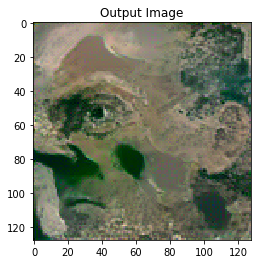

run 150:
Style Loss : 11.058418 Content Loss: 11.762868

run 200:
Style Loss : 9.881805 Content Loss: 11.604029



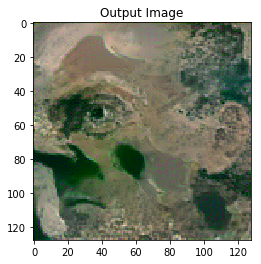

run 250:
Style Loss : 9.150513 Content Loss: 11.551227

run 300:
Style Loss : 8.824658 Content Loss: 11.489987



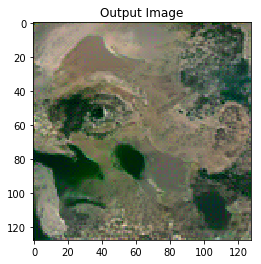

run 350:
Style Loss : 10.764083 Content Loss: 12.109383

run 400:
Style Loss : 8.151844 Content Loss: 11.717679



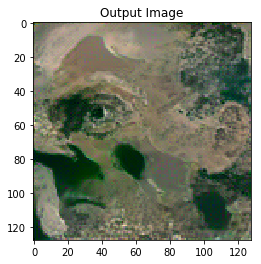

run 450:
Style Loss : 7.458277 Content Loss: 11.438910

run 500:
Style Loss : 7.329886 Content Loss: 11.369610



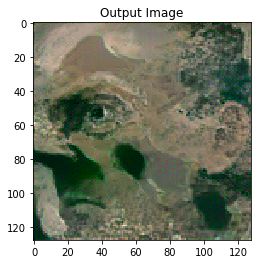

In [ ]:
counter = 0
while counter <= num_steps:
    # correct the values of updated input image
    input_img.data.clamp_(0, 1)

    optimizer.zero_grad()
    model(input_img)
    style_score = 0
    content_score = 0

    for sl in style_losses:
        style_score += sl.loss
    for cl in content_losses:
        content_score += cl.loss

    style_score *= style_weight
    content_score *= content_weight

    loss = style_score + content_score
    loss.backward()  # compute the gradients.

    # plot the loss from time to time...
    counter += 1
    if counter % 50 == 0:
        print("run {}:".format(counter))
        print('Style Loss : {:4f} Content Loss: {:4f}'.format(
            style_score.item(), content_score.item()))
        print()

    if counter % 100 == 0:
        img_plot = input_img.clone().detach().data
        plt.figure()
        imshow(img_plot, title='Output Image')
        save_image(img_plot,
                   'images/in_between/img_' + str(counter) + '.jpg',
                   nrow=4)
        plt.show()
    # gradient descent step
    optimizer.step()

# a last correction...
input_img.data.clamp_(0, 1)


__Observe the result__

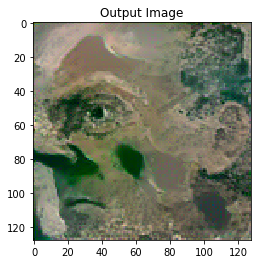

In [88]:
plt.figure()
imshow(input_img, title='Output Image')

# sphinx_gallery_thumbnail_number = 4
plt.ioff()
plt.show()

__Make a GIF out of the image__

In [ ]:
frames = [Image.open('images/in_between/img_' + str(i)) for i in range(9)]
    frames[0].save('gifs/' + gif_name + '.gif',
                   format='GIF',
                   append_images=frames[1:],
                   save_all=True,
                   duration=10,
                   loop=0)